In [107]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

The dataset is located at https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud and requires a Kaggle account to download. It is larger than GitHub's maximum allowed file size 100mb, so for this project we have downloaded and extracted it, then loaded it from the local file system.

In [108]:
# Load dataset
df = pd.read_csv("c:\\sources\\creditcard.csv")

df.shape

(284807, 31)

**Inspect Dataset Structure**

In [109]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [111]:
# Counts of each class
class_counts = df['Class'].value_counts().sort_index()
class_counts

Class
0    284315
1       492
Name: count, dtype: int64

In [112]:
# Check for duplicate rows
num_duplicates = df.duplicated().sum()
num_duplicates

np.int64(1081)

In [113]:
# Remove duplicates
df = df.drop_duplicates().reset_index(drop=True)

print("New shape after removing duplicates:", df.shape)

New shape after removing duplicates: (283726, 31)


**Class Imbalance Recheck**

After removing duplicates, we reconfirm the number of legitimate vs. fraudulent transactions and plot visualisations.

In [114]:
# Basic counts of each class
class_counts = df['Class'].value_counts().sort_index()
class_counts

Class
0    283253
1       473
Name: count, dtype: int64

In [115]:
def plot_class_distribution(labels, title_prefix="Dataset"):
    counts = pd.Series(labels).value_counts().sort_index()

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    counts.plot(kind='bar', color=['steelblue', 'salmon'])
    plt.title(f'{title_prefix}: Class Distribution (0 = Legitimate, 1 = Fraud)')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(rotation=0)

    plt.subplot(1, 2, 2)
    counts.plot(
        kind='pie',
        autopct='%1.2f%%',
        startangle=90,
        colors=['steelblue', 'salmon'],
        labels=['Legitimate', 'Fraud']
    )
    plt.ylabel('')
    plt.title(f'{title_prefix}: Class Percent')

    plt.tight_layout()
    plt.show()

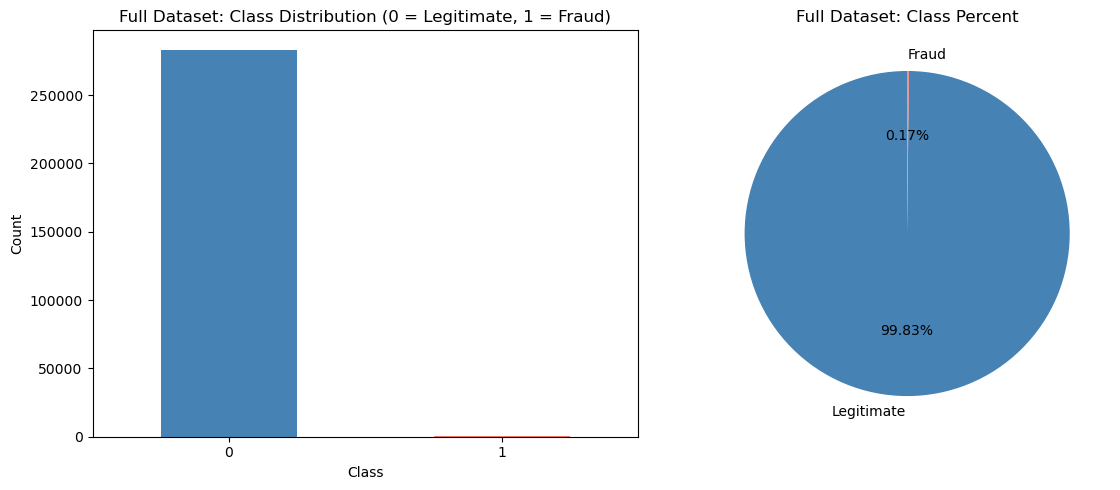

In [116]:
plot_class_distribution(df['Class'], title_prefix="Full Dataset")

**Boxplots for Detecting Outliers**

Because transaction amounts can vary widely and may include extreme outliers, we include boxplots to visualize the distribution of `Amount`. Outliers are common in financial datasets and can be informative for fraud detection, since fraudulent transactions sometimes involve unusually high or low amounts. We generate a class-separated boxplot (legitimate vs. fraud) to compare distributions.

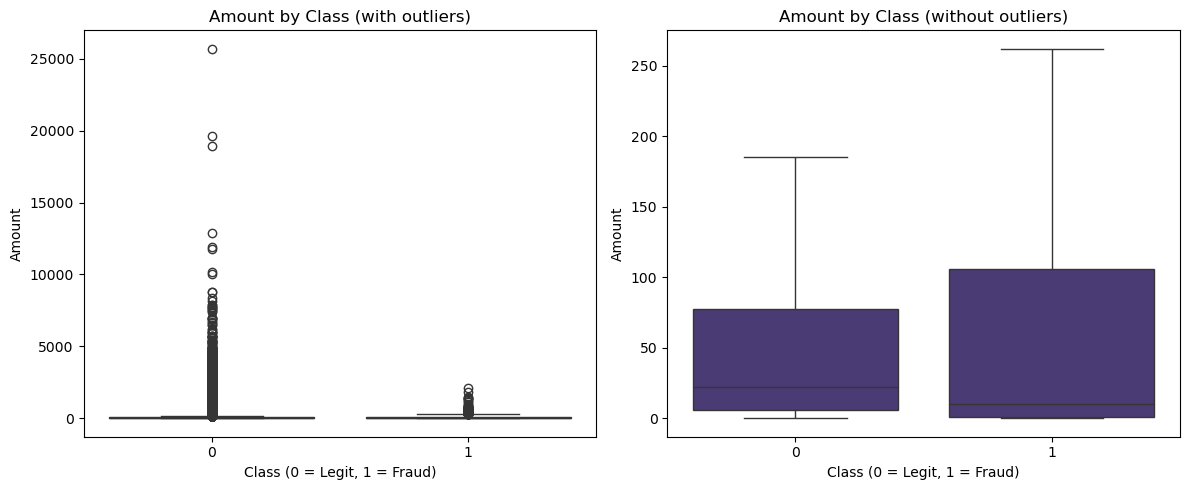

In [117]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,5))

# With outliers
sns.boxplot(ax=ax1, x='Class', y='Amount', data=df, showfliers=True)
ax1.set_title('Amount by Class (with outliers)')
ax1.set_xlabel('Class (0 = Legit, 1 = Fraud)')
ax1.set_ylabel('Amount')

# Without outliers
sns.boxplot(ax=ax2, x='Class', y='Amount', data=df, showfliers=False)
ax2.set_title('Amount by Class (without outliers)')
ax2.set_xlabel('Class (0 = Legit, 1 = Fraud)')
ax2.set_ylabel('Amount')

plt.tight_layout()
plt.show()

**Preparing Features and Target**

To begin the modeling pipeline, we separate the dataset into input features and the target label:

- X: all feature columns except the target  
- y: fraud label (Class), where 1 = fraud and 0 = legitimate  


In [118]:
# Separate features and target
X = df.drop("Class", axis=1)
y = df["Class"]

X.shape, y.shape

((283726, 30), (283726,))

**Train/Test Split**

We use a stratified train/test split so that both sets preserve the extreme class imbalance present in the dataset. Without stratification, the test set could easily end up with very few or even zero fraud cases, leading to unreliable evaluation results.

In [119]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.15,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape

((241167, 30), (42559, 30))

**Scale After Splitting**

Feature scaling must be performed after the train/test split to avoid data leakage.  
If we scale the entire dataset before splitting, the scaling parameters (mean and standard deviation) would be influenced by the test data, giving the model unfair prior knowledge about values it should never see during training.

By fitting the scaler only on the training set and applying the transformation to the test set, we maintain a realistic evaluation scenario that reflects how the model would behave on new, unseen transactions.

We will scale Time and Amount, which are not PCA-transformed and typically need normalization.

In [120]:
# Initialize scaler
scaler = StandardScaler()

# Copy training and test sets to avoid modifying the original dataframe
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Fit scaler only on training data
X_train_scaled[['Time', 'Amount']] = scaler.fit_transform(X_train[['Time', 'Amount']])

# Transform test data using parameters learned from training data
X_test_scaled[['Time', 'Amount']] = scaler.transform(X_test[['Time', 'Amount']])

X_train_scaled.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
83897,-0.729921,1.233270,0.040032,0.134008,0.272556,0.054883,0.244832,-0.223827,0.205438,0.030645,...,-0.170326,-0.247630,-0.773342,0.067363,-0.848483,0.182254,0.162467,-0.025604,-0.005840,-0.357555
171814,0.552718,-0.783823,0.927366,-1.043634,1.065041,2.369544,-0.542584,1.287016,-0.239198,-0.713867,...,0.099626,-0.040171,0.392896,0.202957,-0.071165,0.310242,-0.355486,0.406562,0.220590,-0.357106
98390,-0.590880,1.266865,0.481231,-0.119466,1.112353,0.026039,-1.193853,0.555428,-0.354063,-0.271385,...,-0.148044,0.005526,0.059630,-0.149126,0.405325,0.848880,-0.296838,-0.009259,0.011754,-0.333457
258577,1.354107,-2.083682,2.108832,-2.223863,-0.015583,-0.431835,-1.695080,-0.477952,1.284506,-0.298766,...,-0.502417,0.377555,0.998111,0.182312,-0.076132,-0.136755,-0.148385,-0.307083,-0.069161,-0.352409
133634,-0.299110,-1.760925,1.387821,-0.050880,1.336324,-2.605606,1.388641,1.783186,0.726618,-0.684235,...,-0.260697,-0.044770,0.372187,0.151773,0.247016,-0.023620,-0.235129,0.459238,-0.043548,1.528775


**Baseline Modeling**

Before applying any resampling methods, we train baseline models on the original imbalanced dataset. This gives us a reference point to evaluate how much SMOTE or class-weighting improves performance later.

We evaluate the following models:

- Logistic Regression
- Random Forest
- XGBoost

Because accuracy is misleading under extreme imbalance, we evaluate models using:

- Precision
- Recall
- F1-score
- ROC-AUC


**Functions for collecting metrics to summarize together**

In [121]:
def get_metrics(model, X_test, y_test, name):
    '''Collects precision, recall, F1-score, and ROC-AUC for a given model.'''
    y_pred = model.predict(X_test)
    
    try:
        y_proba = model.predict_proba(X_test)[:, 1] # some models may not have predict_proba
        roc = roc_auc_score(y_test, y_proba)
    except:
        roc = None
    
    return {
        "Model": name,
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC_AUC": roc,
    }

In [122]:
def evaluate_models_dict(models_dict, X_test, y_test, label_suffix=""):
    """
    models_dict: {"LogReg": model_obj, "RF": model_obj, ...}
    label_suffix: appended to the model name for clarity, e.g. 'Baseline' or 'SMOTE'
    """
    results = []
    
    for name, model in models_dict.items():
        full_name = f"{name} - {label_suffix}" if label_suffix else name
        metrics = get_metrics(model, X_test, y_test, full_name)
        results.append(metrics)
    
    return pd.DataFrame(results)

**Model 1 - Logistic Regression**

In [123]:
log_reg = LogisticRegression(max_iter=1000, class_weight=None) # class weight set to None for baseline
log_reg.fit(X_train_scaled, y_train)

get_metrics(log_reg, X_test_scaled, y_test, "Logistic Regression (Baseline)")

{'Model': 'Logistic Regression (Baseline)',
 'Precision': 0.8431372549019608,
 'Recall': 0.6056338028169014,
 'F1': 0.7049180327868853,
 'ROC_AUC': 0.9584545495530138}

### Interpreting Logistic Regression Coefficients

To add interpretability to our baseline models, we examine the coefficients learned by Logistic Regression.  
Each coefficient represents how strongly a feature influences the probability of fraud:

- **Positive coefficients** → increase the predicted probability of fraud  
- **Negative coefficients** → decrease the predicted probability of fraud  
- The **larger the absolute value**, the stronger the effect  

Although the features V1–V28 are PCA-transformed and not directly interpretable, the coefficients still help us understand which components contribute most to the model’s decision boundary.

In [124]:
# Extract coefficients
coef_df = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Coefficient': log_reg.coef_[0]
})

# Sort by absolute coefficient magnitude
coef_df['AbsCoeff'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='AbsCoeff', ascending=False)

coef_df.head(10)  # show top 10 strongest predictors


,Feature,Coefficient,AbsCoeff
14,V14,-0.705018,0.705018
10,V10,-0.626550,0.626550
4,V4,0.610625,0.610625
22,V22,0.499733,0.499733
27,V27,-0.376290,0.376290
16,V16,-0.337530,0.337530
21,V21,0.300775,0.300775
13,V13,-0.283458,0.283458
20,V20,-0.228721,0.228721
8,V8,-0.214634,0.214634


**Model 2 - Random Forest**

In [125]:
rf = RandomForestClassifier(
    warm_start=True,
    n_estimators=200,
    random_state=42,
    class_weight=None,  # baseline: no imbalance handling
    n_jobs=-1           # parallelize across all CPU cores
)

rf.fit(X_train_scaled, y_train)

get_metrics(rf, X_test_scaled, y_test, "Random Forest (Baseline)")

{'Model': 'Random Forest (Baseline)',
 'Precision': 0.9636363636363636,
 'Recall': 0.7464788732394366,
 'F1': 0.8412698412698413,
 'ROC_AUC': 0.9267511489573859}

**Model 3 - XGBoost**

In [126]:
xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    use_label_encoder=False,
    scale_pos_weight=1,  # baseline: no imbalance handling
    n_jobs=-1          # parallelize across all CPU cores
)

xgb.fit(X_train_scaled, y_train)

get_metrics(xgb, X_test_scaled, y_test, "XGBoost (Baseline)")

{'Model': 'XGBoost (Baseline)',
 'Precision': 0.9636363636363636,
 'Recall': 0.7464788732394366,
 'F1': 0.8412698412698413,
 'ROC_AUC': 0.9750139890368383}

**Baseline Results Summary**

These baseline results show how each model performs on the unbalanced dataset. 
Because fraud cases are extremely rare, models typically exhibit high precision but very low recall (they miss most fraud cases).

In [127]:
baseline_models = {
    "LogReg": log_reg,
    "RF": rf,
    "XGBoost": xgb
}

baseline_results = evaluate_models_dict(
    baseline_models,
    X_test_scaled,
    y_test,
    label_suffix="Baseline"
)

baseline_results


,Model,Precision,Recall,F1,ROC_AUC
0,LogReg - Baseline,0.843137,0.605634,0.704918,0.958455
1,RF - Baseline,0.963636,0.746479,0.841270,0.926751
2,XGBoost - Baseline,0.963636,0.746479,0.841270,0.975014


**Modeling with SMOTE (Handling Class Imbalance)**

Next, we apply SMOTE (Synthetic Minority Oversampling Technique) to address the extreme class imbalance in the training data. SMOTE creates synthetic minority (fraud) examples by interpolating between existing ones.

Important points:

- SMOTE is applied only to the training set (X_train_scaled, y_train).
- The test set is left untouched so that evaluation reflects real-world, imbalanced data.
- We retrain the same models (Logistic Regression, Random Forest, XGBoost) on the SMOTE-balanced training data and compare their performance to the baseline models.


In [128]:
sm = SMOTE(random_state=42)

X_train_smote, y_train_smote = sm.fit_resample(X_train_scaled, y_train)

X_train_scaled.shape, y_train.shape, X_train_smote.shape, y_train_smote.shape

((241167, 30), (241167,), (481530, 30), (481530,))

In [129]:
y_train.value_counts(), y_train_smote.value_counts()

(Class
 0    240765
 1       402
 Name: count, dtype: int64,
 Class
 0    240765
 1    240765
 Name: count, dtype: int64)

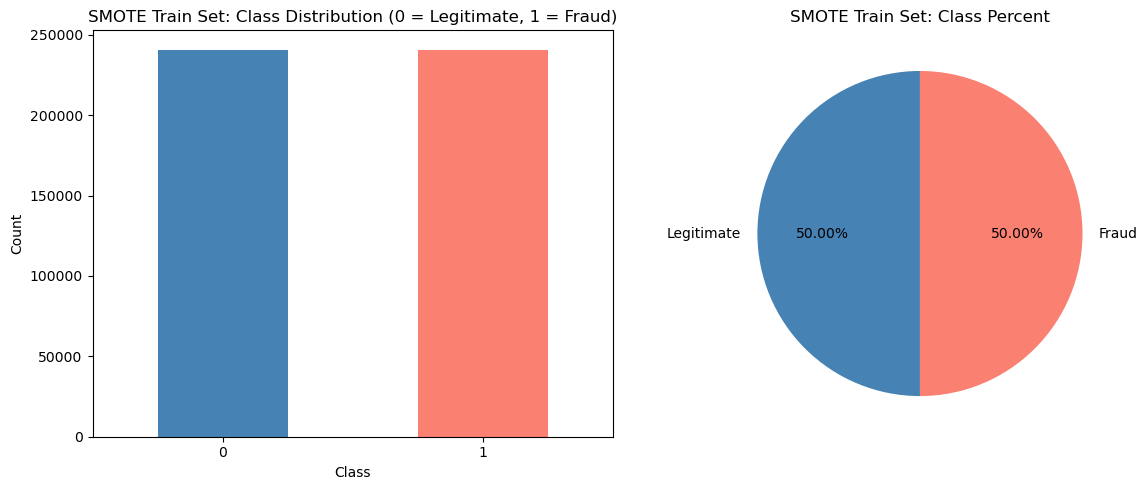

In [130]:
plot_class_distribution(y_train_smote, title_prefix="SMOTE Train Set")

**Model 1 - Logistic Regression with SMOTE**

In [131]:
log_reg_smote = LogisticRegression(max_iter=1000)

log_reg_smote.fit(X_train_smote, y_train_smote)

get_metrics(log_reg_smote, X_test_scaled, y_test, "Logistic Regression (SMOTE)")

{'Model': 'Logistic Regression (SMOTE)',
 'Precision': 0.05285961871750433,
 'Recall': 0.8591549295774648,
 'F1': 0.09959183673469388,
 'ROC_AUC': 0.9640190038744991}

**Model 2 - Random Forest with SMOTE**

In [132]:
rf_smote = RandomForestClassifier(
    warm_start=True,
    n_estimators=200,
    random_state=42,
    n_jobs=-1  # parallelize
)

rf_smote.fit(X_train_smote, y_train_smote)

get_metrics(rf_smote, X_test_scaled, y_test, "Random Forest (SMOTE)")

{'Model': 'Random Forest (SMOTE)',
 'Precision': 0.873015873015873,
 'Recall': 0.7746478873239436,
 'F1': 0.8208955223880597,
 'ROC_AUC': 0.961125063315309}

**Model 3 - XGBoost with SMOTE**

In [133]:
xgb_smote = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    use_label_encoder=False,
    n_jobs=-1
)

xgb_smote.fit(X_train_smote, y_train_smote)

get_metrics(xgb_smote, X_test_scaled, y_test, "XGBoost (SMOTE)")

{'Model': 'XGBoost (SMOTE)',
 'Precision': 0.59375,
 'Recall': 0.8028169014084507,
 'F1': 0.6826347305389222,
 'ROC_AUC': 0.9747947059119925}

**SMOTE vs. Baseline Comparison**

Comparing the SMOTE-balanced models to the baseline results, we can observe the typical trade-off:

- Recall generally increases after applying SMOTE, meaning the models identify a higher proportion of fraudulent transactions.
- Precision may decrease, since oversampling the minority class often leads to more false positives.
- F1-score often improves if the gain in recall outweighs the loss in precision.
- ROC-AUC may increase or stay similar, depending on the model.

This trade-off is common in fraud detection: missing fraud (low recall) can be more costly than investigating extra false positives. In practice, the "best" model is the one that balances recall and precision in a way that matches business requirements and risk tolerance.


In [134]:
all_models = {
    "LogReg": log_reg,
    "LogReg - SMOTE": log_reg_smote,
    "RF": rf,
    "RF - SMOTE": rf_smote,
    "XGBoost": xgb,
    "XGBoost - SMOTE": xgb_smote
}

all_results = evaluate_models_dict(
    all_models,
    X_test_scaled,
    y_test,
    label_suffix=""
)

all_results

,Model,Precision,Recall,F1,ROC_AUC
0,LogReg,0.843137,0.605634,0.704918,0.958455
1,LogReg - SMOTE,0.052860,0.859155,0.099592,0.964019
2,RF,0.963636,0.746479,0.841270,0.926751
3,RF - SMOTE,0.873016,0.774648,0.820896,0.961125
4,XGBoost,0.963636,0.746479,0.841270,0.975014
5,XGBoost - SMOTE,0.593750,0.802817,0.682635,0.974795


In [147]:
def plot_feature_importances_comparison(baseline_model, smote_model, X_train, model_name, top_n=10):
    """
    Show side-by-side feature-importance bar charts for a baseline model and its SMOTE-trained counterpart.
    """
    model_frames = {}
    for label, model in [("Baseline", baseline_model), ("SMOTE", smote_model)]:
        model_frames[label] = (
            pd.DataFrame({"Feature": X_train.columns, "Importance": model.feature_importances_})
            .sort_values(by="Importance", ascending=False)
        )

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))
    sns.barplot(data=model_frames["Baseline"].head(top_n), x="Importance", y="Feature",
                hue="Feature", palette="viridis", legend=False, ax=ax1)
    ax1.set_title(f"Top {top_n} {model_name} (Baseline)")

    sns.barplot(data=model_frames["SMOTE"].head(top_n), x="Importance", y="Feature",
                hue="Feature", palette="viridis", legend=False, ax=ax2)
    ax2.set_title(f"Top {top_n} {model_name} (SMOTE)")

    plt.tight_layout()
    plt.show()

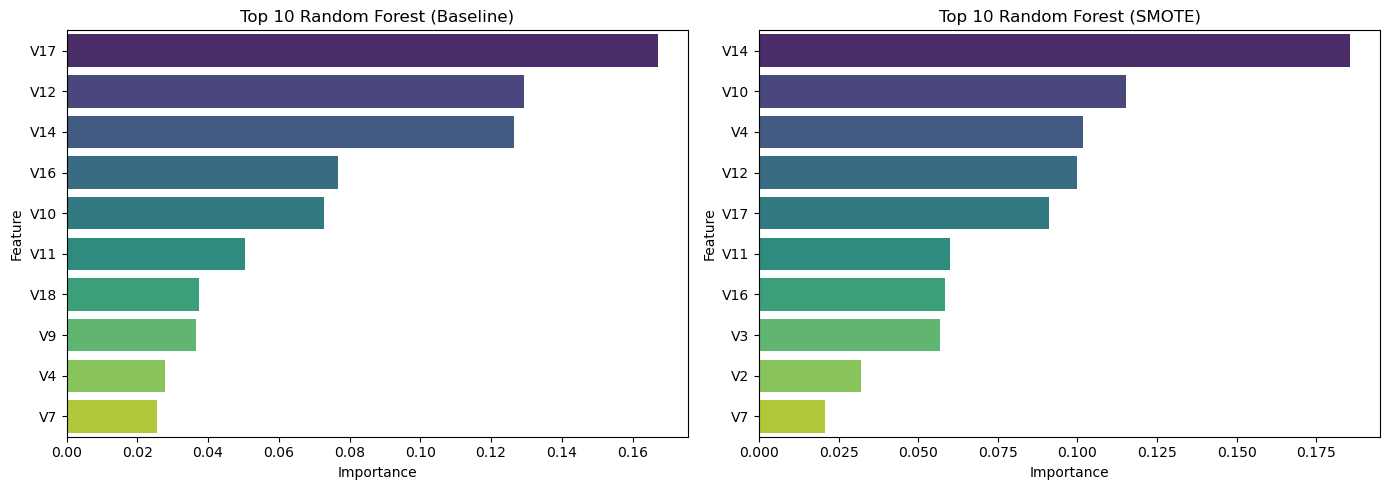

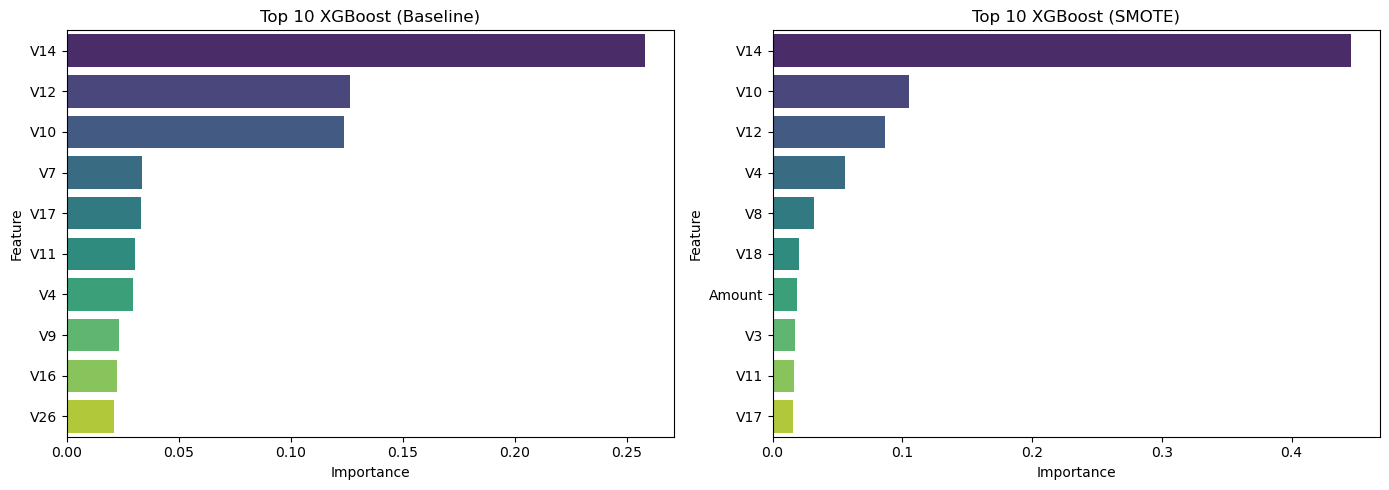

In [146]:
# Compare Random Forest
plot_feature_importances_comparison(rf, rf_smote, X_train_scaled, "Random Forest")

# Compare XGBoost
plot_feature_importances_comparison(xgb, xgb_smote, X_train_scaled, "XGBoost")